# Multimodal Prediction using TextPredictor

본 핸즈온에서는 TextPredictor로 multimodal 데이터를 훈련합니다.

텍스트 데이터는 수치형/범주형 데이터과 같이 사용될 수 있습니다. AutoGluon의 TextPredictor는 텍스트, 범주 및 수치형 컬럼을 비롯한 여러 피쳐들을 입력으로 받아 모델을 자동으로 훈련할 수 있습니다.

- 텍스트 열: 사전 훈련된 Transformer(BERT) backbone을 사용하여 데이터를 인코딩합니다. 
- 범주형 열: Embedding-MLP을 통해 범주형 데이터를 인코딩합니다.
- 수치형 열: 표준 MLP를 사용하여 범주형 데이터를 인코딩합니다.

## TextPredictor & TabularPredictor

TextPredictor로도 multimodal 데이터의 훈련이 가능하지만, 만약 XGBoost/LightGBM/CatBoost 등의 Gradient Boosted Tree 알고리즘을 앙상블 및 스태킹하여 모델링하고 싶다면, `TabularPredictor.fit (..., hyperparameters = 'multimodal')`로 훈련할 수도 있습니다. `hyperparameters = 'multimodal'`을 지정하지 않고 훈련 시, AutoGluon Tabular는 텍스트 데이터를 N-gram으로 자동으로 변환 후 tabular 모델만 훈련합니다. 

In [1]:
# GPU 인스턴스를 사용하시면 아래 주석을 해제하고 본 코드 셀을 실행해 주세요.
# !pip install --upgrade mxnet-cu100

In [2]:
import os
import mxnet as mx
num_gpus = mx.context.num_gpus()

if num_gpus == 0:
    os.environ['AUTOGLUON_TEXT_TRAIN_WITHOUT_GPU'] = '1'

print(num_gpus)    

1


In [3]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
np.random.seed(123)

%load_ext autoreload
%autoreload 2

In [4]:
!python3 -m pip install openpyxl

<br>

## 1. Data preparation and Training

본 핸즈온은 MachineHack Salary Prediction Hackathon의 도서 가격 예측 데이터셋을 사용합니다. 저자, 초록, 책의 등급 등과 같은 다양한 피쳐를 고려하여 도서의 가격을 예측합니다.

### Data preparation

In [5]:
save_path = 'ag-03-multimodal-textpredictor'
!rm -rf $save_path price_of_books

In [6]:
!mkdir -p price_of_books
!wget https://automl-mm-bench.s3.amazonaws.com/machine_hack_competitions/predict_the_price_of_books/Data.zip -O price_of_books/Data.zip
!cd price_of_books && unzip -o Data.zip
!ls price_of_books/Participants_Data

--2021-04-03 10:20:10--  https://automl-mm-bench.s3.amazonaws.com/machine_hack_competitions/predict_the_price_of_books/Data.zip
Resolving automl-mm-bench.s3.amazonaws.com (automl-mm-bench.s3.amazonaws.com)... 52.217.42.228
Connecting to automl-mm-bench.s3.amazonaws.com (automl-mm-bench.s3.amazonaws.com)|52.217.42.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3521673 (3.4M) [application/zip]
Saving to: ‘price_of_books/Data.zip’

price_of_books/Data 100%[===================>]   3.36M  2.41MB/s    in 1.4s    

2021-04-03 10:20:13 (2.41 MB/s) - ‘price_of_books/Data.zip’ saved [3521673/3521673]

Archive:  Data.zip
  inflating: Participants_Data/Data_Test.xlsx  
  inflating: Participants_Data/Data_Train.xlsx  
  inflating: Participants_Data/Sample_Submission.xlsx  
Data_Test.xlsx	Data_Train.xlsx  Sample_Submission.xlsx


In [7]:
train_df = pd.read_excel(os.path.join('price_of_books', 'Participants_Data', 'Data_Train.xlsx'), engine='openpyxl')
train_df.head()

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,"Paperback,– 10 Mar 2016",4.0 out of 5 stars,8 customer reviews,THE HUNTERS return in their third brilliant no...,Action & Adventure (Books),Action & Adventure,220.00
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,"Paperback,– 7 Nov 2012",3.9 out of 5 stars,14 customer reviews,A layered portrait of a troubled genius for wh...,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93
2,Leviathan (Penguin Classics),Thomas Hobbes,"Paperback,– 25 Feb 1982",4.8 out of 5 stars,6 customer reviews,"""During the time men live without a common Pow...",International Relations,Humour,299.00
3,A Pocket Full of Rye (Miss Marple),Agatha Christie,"Paperback,– 5 Oct 2017",4.1 out of 5 stars,13 customer reviews,A handful of grain is found in the pocket of a...,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00
4,LIFE 70 Years of Extraordinary Photography,Editors of Life,"Hardcover,– 10 Oct 2006",5.0 out of 5 stars,1 customer review,"For seven decades, ""Life"" has been thrilling t...",Photography Textbooks,"Arts, Film & Photography",965.62


In [8]:
def preprocess(df):
    df = df.copy(deep=True)
    df.loc[:, 'Reviews'] = pd.to_numeric(df['Reviews'].apply(lambda ele: ele[:-len(' out of 5 stars')]))
    df.loc[:, 'Ratings'] = pd.to_numeric(df['Ratings'].apply(lambda ele: ele.replace(',', '')[:-len(' customer reviews')]))
    df.loc[:, 'Price'] = np.log(df['Price'] + 1)
    return df

In [9]:
train_subsample_size = 1500  # subsample for faster demo, you can try setting to larger values
test_subsample_size = 5
train_df = preprocess(train_df)
train_data = train_df.iloc[100:].sample(train_subsample_size, random_state=123)
test_data = train_df.iloc[:100].sample(test_subsample_size, random_state=245)
train_data.head()

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price
949,Furious Hours,Casey Cep,"Paperback,– 1 Jun 2019",4.0,NaN,‘It’s been a long time since I picked up a boo...,True Accounts (Books),"Biographies, Diaries & True Accounts",5.743003
5504,REST API Design Rulebook,Mark Masse,"Paperback,– 7 Nov 2011",5.0,NaN,"In todays market, where rival web services com...","Computing, Internet & Digital Media (Books)","Computing, Internet & Digital Media",5.786897
5856,The Atlantropa Articles: A Novel,Cody Franklin,"Paperback,– Import, 1 Nov 2018",4.5,2.0,#1 Amazon Best Seller! Dystopian Alternate His...,Action & Adventure (Books),Romance,6.893656
4137,Hickory Dickory Dock (Poirot),Agatha Christie,"Paperback,– 5 Oct 2017",4.3,21.0,There’s more than petty theft going on in a Lo...,Action & Adventure (Books),"Crime, Thriller & Mystery",5.192957
3205,The Stanley Kubrick Archives (Bibliotheca Univ...,Alison Castle,"Hardcover,– 21 Aug 2016",4.6,3.0,"In 1968, when Stanley Kubrick was asked to com...",Cinema & Broadcast (Books),Humour,6.889591


### Training

시간을 절약하기 위해 데이터를 서브샘플링하고 2분 동안만 훈련합니다. 도서의 가격을 예측하는 Regression 모델이기에, RMSE(Root Mean Squared Error)가 디폴트 metric입니다.

INFO:root:NumPy-shape semantics has been activated in your code. This is required for creating and manipulating scalar and zero-size tensors, which were not supported in MXNet before, as in the official NumPy library. Please DO NOT manually deactivate this semantics while using `mxnet.numpy` and `mxnet.numpy_extension` modules.
INFO:autogluon.text.text_prediction.mx.models:The GluonNLP V0 backend is used. We will use 4 cpus and 1 gpus to train each trial.


All Logs will be saved to /home/ec2-user/SageMaker/autogluon-on-aws/2.nlp/ag-03-multimodal-textpredictor/task0/training.log


INFO:root:Fitting and transforming the train data...
INFO:root:Done! Preprocessor saved to /home/ec2-user/SageMaker/autogluon-on-aws/2.nlp/ag-03-multimodal-textpredictor/task0/preprocessor.pkl
INFO:root:Process dev set...
INFO:root:Done!
INFO:root:Max length for chunking text: 480, Stochastic chunk: Train-False/Test-False, Test #repeat: 1.
INFO:root:#Total Params/Fixed Params=109338913/0
Level 15:root:Using gradient accumulation. Global batch size = 128
INFO:root:Local training results will be saved to /home/ec2-user/SageMaker/autogluon-on-aws/2.nlp/ag-03-multimodal-textpredictor/task0/results_local.jsonl.
Level 15:root:[Iter 1/100, Epoch 0] train loss=2.78e+00, gnorm=7.03e+01, lr=1.00e-05, #samples processed=128, #sample per second=5.00. ETA=42.25min
Level 15:root:[Iter 2/100, Epoch 0] train loss=1.85e+00, gnorm=3.65e+01, lr=2.00e-05, #samples processed=128, #sample per second=5.21. ETA=40.96min
Level 25:root:[Iter 2/100, Epoch 0] valid r2=-8.3807e-01, root_mean_squared_error=1.0906e+

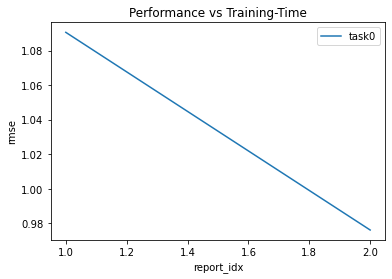

INFO:root:Training completed. Auto-saving to "ag-03-multimodal-textpredictor/". For loading the model, you can use `predictor = TextPredictor.load("ag-03-multimodal-textpredictor/")`


In [10]:
from autogluon.text import TextPredictor
time_limit = 2 * 60  # set to larger value in your applications
predictor = TextPredictor(label='Price', path=save_path)
predictor.fit(train_data, time_limit=time_limit)

<br>

## 2. Prediction

In [11]:
predictions = predictor.predict(test_data)
print('Predictions:')
print('------------')
print(np.exp(predictions) - 1)
print()
print('True Value:')
print('------------')
print(np.exp(test_data['Price']) - 1)

Predictions:
------------
1      606.085999
31     645.757874
19    1181.846680
45    1355.217407
82    1138.167480
Name: Price, dtype: float32

True Value:
------------
1     202.93
31    799.00
19    352.00
45    395.10
82    409.00
Name: Price, dtype: float64


In [12]:
performance = predictor.evaluate(test_data)
print(performance)

1.0253359079360962


In [13]:
embeddings = predictor.extract_embedding(test_data)
print(embeddings)

[[-0.27092642  0.1401582  -0.09910554 ...  0.11673778 -0.09213806
   0.03709367]
 [-0.19558154  0.23744594 -0.11637109 ...  0.00473959 -0.03823385
   0.02328855]
 [-0.2608093   0.3268228  -0.15648955 ... -0.48997772  0.38420254
   0.24232599]
 [-0.25369692  0.2165618  -0.146528   ... -0.0716395   0.02360643
   0.30796123]
 [-0.37136218  0.41238376 -0.03291351 ...  0.05975762 -0.11187598
   0.18020561]]
